In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [21]:
df  = pd.read_csv('congressional_voting_dataset.csv')
def encode(x):
    if x == "n":
        return -1
    if x == "?":
        return 0
    if x == "y":
        return 1
    if x == "republican":
        return -1
    if x == "democrat":
        return 1

df = df.drop_duplicates()
df = df.applymap(encode)
    
X = pd.DataFrame(df)
y = pd.DataFrame( X["political_party"])
X.drop( columns = ["political_party"], inplace=True )


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=1)
   
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size=0.25, random_state=1)


# Modelowanie

Sprawdzam różne modele oraz tuninguje je różnymi metodami, aby uzyskać jak najwyższe accuracy. Jest to dobra miara do naszego zbioru poniważ obie wartości targetu są dla nas tak samo istotne więc, ta miara sprowadza się do procentowej ilości poprawnych trafień.

In [3]:
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#### Model drzewa

Wytrenowałem model pojedyńczego drzewa tuningując go za pomocą GridSearch. Uzyskałem 91% w accuracy. Traktuję to jako baseline i teraz spróbuję znaleźć lepszy model.

In [14]:
tree = DecisionTreeClassifier()

param_grid = {"max_depth": range(3,16,3),
              "max_features": range(1, 40,5),
              "min_samples_leaf": range(1, 40,5),
              "criterion": ["gini", "entropy"]}


tree_Gcv = GridSearchCV(tree, param_grid, cv = 5)
tree_Gcv.fit(X_train, y_train)
print('Accuracy drzewa test: ' + str(round(tree_Gcv.score(X_test, y_test),3)))
print('Accuracy drzewa val: ' + str(round(tree_Gcv.score(X_val, y_val),3)))

Accuracy drzewa test: 0.942
Accuracy drzewa val: 0.87


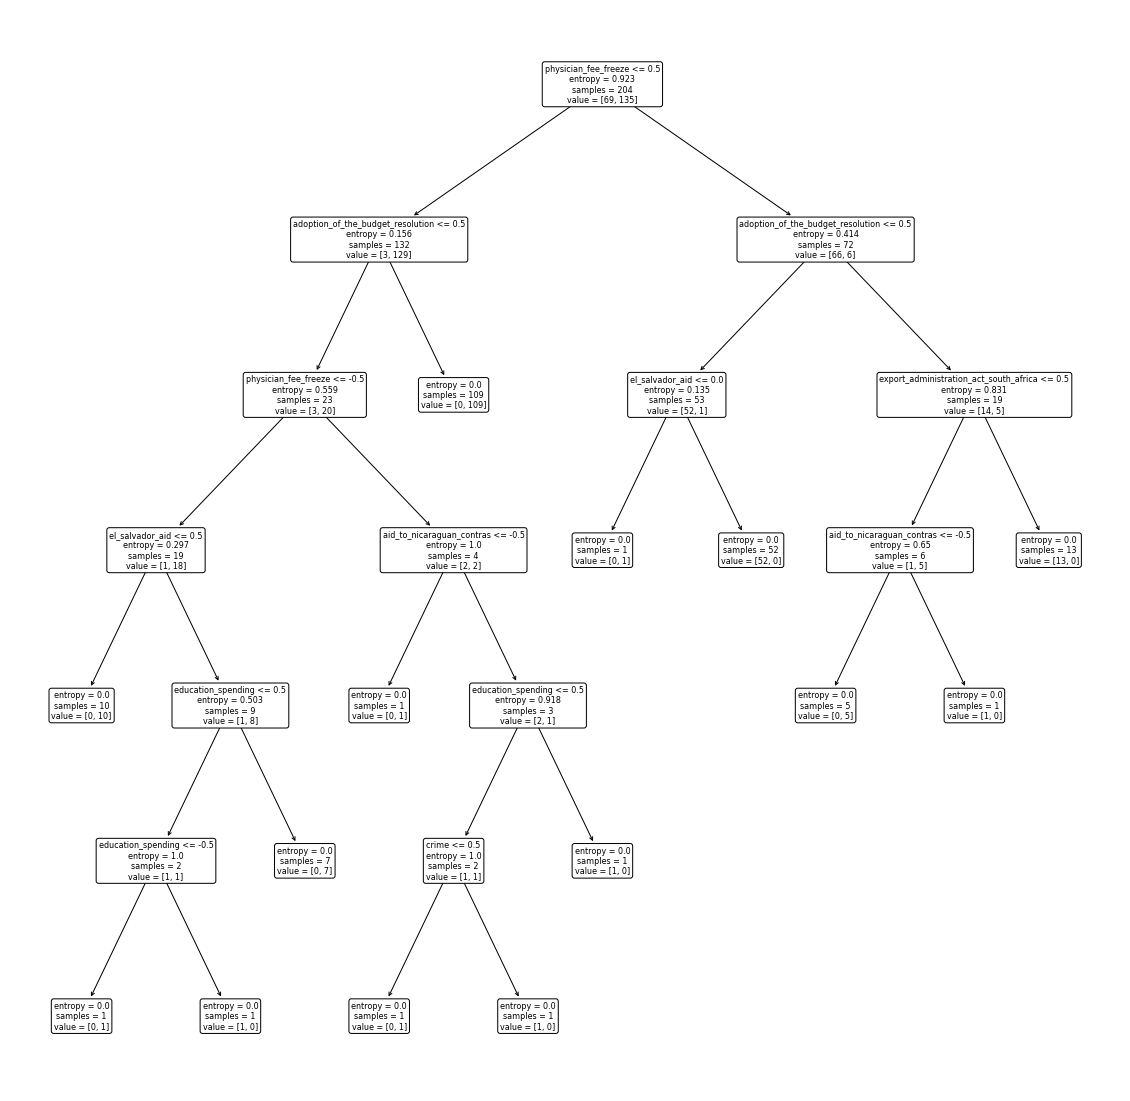

In [15]:
plt.figure(figsize=(20,20))
plot_tree(tree_Gcv.best_estimator_, feature_names=X_train.columns.values, fontsize=8, rounded=True, )
plt.show()

### Random Forest

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 16, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print('Accuracy Random Forest test: ' + str(round(rf_random.score(X_test, y_test), 3)))
print('Accuracy Random Forest val: ' + str(round(rf_random.score(X_val, y_val), 3)))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy Random Forest test: 0.971
Accuracy Random Forest val: 0.899


In [25]:
random_grid

{'n_estimators': [200, 233, 266, 300, 333, 366, 400, 433, 466, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 11, 12, 13, 14, 16, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4, 8, 12],
 'bootstrap': [True, False]}

## Logistic Regresion

In [200]:
lr = LogisticRegression()
grid = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20)}
lr_Gcv = GridSearchCV(lr, param_grid=grid, cv=10)
lr_Gcv.fit(X_train, y_train)
print('Accuracy Logistic Regresion test: ' + str(round(lr_Gcv.score(X_test, y_test), 3)))
print('Accuracy Logistic Regresion val: ' + str(round(lr_Gcv.score(X_val, y_val), 3)))

Accuracy Logistic Regresion test: 0.971
Accuracy Logistic Regresion val: 0.913


## Bayes

In [201]:
bayes = GaussianNB()
grid = {'var_smoothing': np.logspace(0,-9, num=100)}
bye_Gsv = GridSearchCV(bayes, param_grid=grid, cv = 10)
bye_Gsv.fit(X_train, y_train)
bye_Gsv.score(X_val, y_val)
print('Accuracy Bayes test: ' + str(round(bye_Gsv.score(X_test, y_test), 3)))
print('Accuracy Bayes val: ' + str(round(bye_Gsv.score(X_val, y_val), 3)))

Accuracy Bayes test: 0.957
Accuracy Bayes val: 0.884


## KNN

In [23]:
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': np.arange(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski' , 'manhattan']
}
knn_Gsv = GridSearchCV(knn, param_grid=grid, cv = 10)
knn_Gsv.fit(X_train, y_train)
print('Accuracy KNN test: ' + str(round(knn_Gsv.score(X_test, y_test), 3)))
print('Accuracy KNN val: ' + str(round(knn_Gsv.score(X_val, y_val), 3)))

Accuracy KNN test: 0.957
Accuracy KNN val: 0.884


## AdaBoost

In [203]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [204]:
ada = AdaBoostClassifier()
grid = {
    'n_estimators' : [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 0.9]
}
ada_Gcv = GridSearchCV(ada, param_grid=grid, cv = 10)
ada_Gcv.fit(X_train, y_train)
print('Accuracy AdaBoost: ' + str(round(ada_Gcv.score(X_test, y_test), 3)))

Accuracy AdaBoost: 0.971


In [208]:
print('Accuracy AdaBoost: ' + str(round(ada_Gcv.score(X_val, y_val), 3)))

Accuracy AdaBoost: 0.884


In [205]:
ada2 = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.9)
ada2.fit(X_train, y_train)
ada2.score(X_val, y_val)

0.9710144927536232

In [206]:
df  = pd.read_csv('congressional_voting_dataset.csv')
def encode(x):
    if x == "n":
        return -1
    if x == "?":
        return 0
    if x == "y":
        return 1
    if x == "republican":
        return -1
    if x == "democrat":
        return 1

df = df.drop_duplicates()
df = df.applymap(encode)
    
X = pd.DataFrame(df)
y = pd.DataFrame( X["political_party"])
X.drop( columns = ["political_party"], inplace=True )


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=1)
   
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size=0.25, random_state=1)


In [207]:
alf = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.9)
alf.fit(X_train, y_train)
alf.score(X_val, y_val)

0.9710144927536232

In [214]:
def c_matrix(model, X, y):
    y_val_hat = model.predict(X)
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_val_hat.round())
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

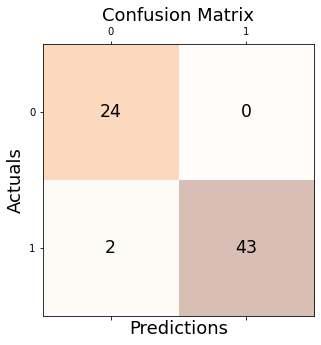

In [215]:
c_matrix(lr_Gcv, X_test, y_test)